## Experiments with PageRank

In [1]:
import matplotlib.pyplot as plt
import networkit as nk
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from fast_pagerank import pagerank
from fast_pagerank import pagerank_power
from scipy import sparse
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity

import utils

In [2]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

# Filter out small product categories
# top_categories = utils.find_top_n_categories(df_data, top_n=10)
top_categories = [
#     'Folders',                         # N=645
#     'Self-Adhesive Labels',            # N=324
#     'Multimedia Carts & Stands',       # N=317
#     'Calculators',                     # N=305
#     'Writing Notebooks'                # N=300
#     'Ring Binders',                    # N=298
#     'Printer Cabinets & Stands',       # N=252
    'Whiteboards',                     # N=232
#    'Fax Machines',                    # N=210
    'File Storage Boxes'               # N=192
]
df_data = df_data[df_data.category_name.isin(top_categories)]

# Sort by category for later visualisation
df_data.sort_values('category_name', inplace=True)

product_features = utils.get_product_feature_columns_for_training(df_data)
df_play_data = df_data[['category_name'] + product_features].copy()

In [3]:
df_data.category_name.value_counts()

Whiteboards           232
File Storage Boxes    192
Name: category_name, dtype: int64

In [4]:
X = utils.preprocess_dataframe(df_play_data)
X.shape

(424, 183)

In [5]:
# Reduce to number of dimensions so the remaining dimensions
# explain at least 90 percent of the variance.
svd = PCA(n_components=0.9, random_state=42)
X_transformed = svd.fit_transform(X)
X_transformed.shape

(424, 19)

In [6]:
similarity_matrix = cosine_similarity(X)

# Ensure similarity matrix entries are normalised in the range [0,1]
similarity_matrix = (similarity_matrix - np.min(similarity_matrix)) / np.ptp(similarity_matrix)

In [7]:
np.min(similarity_matrix), np.max(similarity_matrix)

(0.0, 1.0)

<AxesSubplot:>

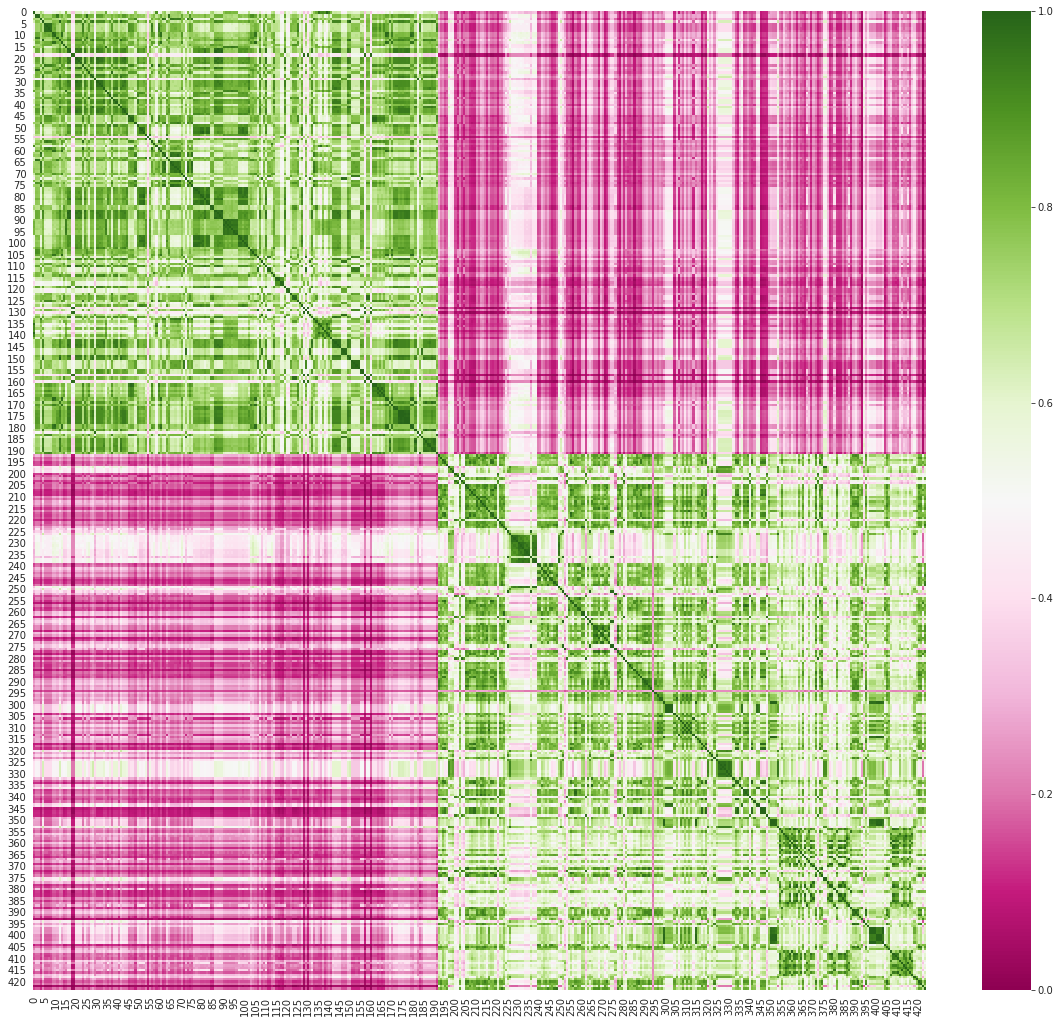

In [8]:
# similarity_matrix = rbf_kernel(X_transformed)
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(similarity_matrix, cmap="PiYG", ax=ax)

## Community Detection

In [9]:
g = nk.Graph(weighted=True, directed=False)

n = similarity_matrix.shape[0]
g.addNodes(n)
for i in range(n):
    for j in range(i, n):
        if i != j:
            g.addEdge(i, j, similarity_matrix[i, j])

In [10]:
communities = nk.community.detectCommunities(g)

PLM(balanced,pc,turbo) detected communities in 0.008159875869750977 [s]
solution properties:
-------------------  ----------
# communities          2
min community size   192
max community size   232
avg. community size  212
modularity             0.225231
-------------------  ----------


In [11]:
nk.community.Modularity().getQuality(communities, g)

0.22523119210610942

## Personalised PageRank

In [12]:
weighted_graph = nx.from_numpy_matrix(similarity_matrix)

In [13]:
ppr = nx.pagerank(weighted_graph, max_iter=1, tol=1e-03, personalization={10: 1.0})

In [14]:
ppr

{0: 0.001692215606961097,
 1: 0.0021225082468232215,
 2: 0.0021028675493387286,
 3: 0.0018456946834300525,
 4: 0.0022787817499669333,
 5: 0.001900822963850787,
 6: 0.001895418983375758,
 7: 0.0018986179460607515,
 8: 0.0019097700872918995,
 9: 0.002127318183180925,
 10: 0.15212498246484157,
 11: 0.002100443369634169,
 12: 0.0022787817499669333,
 13: 0.002136795639735174,
 14: 0.0020467905571017538,
 15: 0.0020235328268207956,
 16: 0.0022331252224513064,
 17: 0.002229449020374693,
 18: 0.0012140287704017348,
 19: 0.0012106591780303674,
 20: 0.0022330361760095224,
 21: 0.0022263864363203135,
 22: 0.0022248979622976474,
 23: 0.001960597631639676,
 24: 0.0022182614892814942,
 25: 0.0021076007879453676,
 26: 0.0019512970288896262,
 27: 0.002225491197267917,
 28: 0.002291806271236457,
 29: 0.0016770485396548434,
 30: 0.0021738692245311156,
 31: 0.0021684492597236027,
 32: 0.0021715633477314166,
 33: 0.0022363460440643925,
 34: 0.002013530413453882,
 35: 0.001975131534257885,
 36: 0.002148143